In [33]:
import os
import json
from typing import Union, Optional, Tuple, List, Set

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import PretrainedConfig, PreTrainedTokenizerFast
from transformers.models.bart.modeling_bart import BartForConditionalGeneration

# Dataset

AIHub에서 다운 받은 [문서요약 텍스트 데이터셋](https://aihub.or.kr/aidata/8054)을 불러옵니다. 

아래의 `dataset_file`에 `.jsonl` 확장자 형태로 된 파일경로를 입력하면 json으로 불러오게 됩니다.

In [34]:
dataset_file = "sample_data/labeled_data/newspaper/sample.jsonl"

with open(dataset_file, "r") as json_files:
    json_list = list(json_files)

raw_data = []
for json_str in json_list:
    result = json.loads(json_str)
    raw_data.append(result)

dataset_df = pd.DataFrame(raw_data)
dataset_df.head()

,id,abstractive,extractive,article_original,media
0,353465974,충주시는 민간보조사업의 증가와 보조금 집행관리에 대한 부당 행위가 증가함에따라 15...,"[2, 3, 5]","[보조금 집행 위법행위·지적사례 늘어, 특별감사반, 2017~2018년 축제 점검,...",충청투데이
1,366398381,국무조정실은 8일 오후 대전시청에서 '대전지역 규제혁신 현장간담회'를 열고 대전과 ...,"[4, 6, 14]","[8일 대전시청에서 규제혁신 간담회, 도시개발 산업용지도 특화단지 지정가능, 국무조...",중도일보
2,360025161,중국 경제일간지 21세기경제보도는 중국 대형 생명보험사인 차이나라이프가 '차이나라이...,"[0, 1, 2]",[중국 경제일간지 21세기경제보도는 중국 대형 생명보험사인 차이나라이프(中國人壽)가...,내일신문
3,361884128,1일 대검찰청은 '조속한 검찰개혁 방안을 마련하라'는 문재인 대통령의 지시에 따라...,"[4, 5, 3]","[전승표 기자, 대검, 文 지시에 발빠른 방안 마련 서울중앙지검 3곳 빼고 모두 폐...",기호일보
4,351452460,제주도가 민선 7기 출범과 함께 조직개편을 추진하면서 지난해 8월 공무원 정원을 2...,"[6, 11, 7]",[제주도가 공무원 정원 102명 증원을 추진하고 있는 가운데 제주도청 조직 및 인력...,한라일보


`extractive`와 `abstractive`의 두 개의 column이 존재하는 것을 볼 수 있는데,

`extractive`는 `article_original`의 문장들 중 문장 요약에 중요한 3개의 문장의 index를 의미합니다.

In [35]:
raw_data[0]["extractive"]
# indicies of extractive summary

[2, 3, 5]

In [36]:
raw_data[0]["article_original"]

['보조금 집행 위법행위·지적사례 늘어',
 '특별감사반, 2017~2018년 축제 점검',
 '충주시가 민간에게 지원되는 보조사업의 대형축제와 관련해 선정·집행·정산 등 운영실태 전반에 대한 자체 감사를 실시할 계획이라고 밝혔다.',
 '이는 최근 민간보조사업의 증가와 더불어 보조금 집행관리에 대한 위법 부당 행위와 지적사례가 지속적으로 증가함에 따라, 감사를 통해 취약요인을 점검해 올바른 보조금 사용 풍토를 정착시키겠다는 취지다.',
 '시는 감사담당관실과 기획예산과 보조금 관련 주무관으로 특별감사반을 편성해 2017년부터 2018년까지 집행된 축제성 보조금 집행에 대한 철저한 점검과 감사를 통해 부정 수급 및 부정 집행이 확인되면 엄정한 조치를 취할 방침이다.',
 '시는 지난 15일부터 25일까지 10일간의 사전감사를 통해 보조금 실태를 파악한 후, 8월15일까지 세부감사를 진행할 예정이라고 전했다.',
 '축제성 관련 부정수급 유형을 보면 허위·기타 부정한 방법으로 보조금 신청, 사업 실적을 부풀려 보조금을 횡령·편취, 보조금 교부 목적과 다른 용도로 집행, 보조금으로 취득한 재산에 대해 지자체장의 승인없이 임의 처분 등이 해당된다.',
 "시는 불법보조금 근절과 효율적인 점검 및 적극적인 시민관심을 유도하기 위해 '지방보조금 부정수급 신고센터(☏850-5031)'를 설치 운영하고 있다.",
 '지방보조금 부정수급 신고 시 직접방문 및 국민신문고(www.epeople.or.kr), 충주시홈페이지(www.chungju.or.kr)를 통해 접수하면 되고, 신고취지와 이유를 기재하고 부정행위와 관련한 증거자료를 제시하면 된다.',
 '단, 익명 신고는 접수치 않는다.',
 '시 관계자는 "이번 자체 점검 및 감사를 통해 축제보조금이 제대로 쓰이는지에 대한 반성과 함께 보조금 집행의 투명성 및 행정의 신뢰성을 확보하는데 최선을 다하겠다"고 말했다.',
 '한편. 시는 감사 및 예산부서 합동으로 컨설팅 위주의 상반기 보조금 특정감사(1월10일~20일)를 실시해

In [37]:
idx = 0
[raw_data[idx]["article_original"][i] for i in raw_data[idx]["extractive"]]

['충주시가 민간에게 지원되는 보조사업의 대형축제와 관련해 선정·집행·정산 등 운영실태 전반에 대한 자체 감사를 실시할 계획이라고 밝혔다.',
 '이는 최근 민간보조사업의 증가와 더불어 보조금 집행관리에 대한 위법 부당 행위와 지적사례가 지속적으로 증가함에 따라, 감사를 통해 취약요인을 점검해 올바른 보조금 사용 풍토를 정착시키겠다는 취지다.',
 '시는 지난 15일부터 25일까지 10일간의 사전감사를 통해 보조금 실태를 파악한 후, 8월15일까지 세부감사를 진행할 예정이라고 전했다.']

따라서 최종 프로젝트에서는 extractive와 abstractive를 단일 모델을 이용하여 모델링을 하고자 합니다.

# Load Pretrained Model

기본 베이스라인으로는 HuggingFace의 gogamza/kobart-summarization 을 사용합니다. 

해당 모델을 불러와서 모델의 구조를 출력하면 아래와 같습니다.

```python
BartForConditionalGeneration(
    (model): BartModel(
        (shared): Embedding(30000, 768. padding_idx=3)
        (encoder): BartEncoder(
            (embed_tokens): Embedding(30000, 768, padding_idx=3)
            (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
            (layers): ModuleList(
                (0): BartEncoderLayer( ... ) ...
                (5): BartEncoderLayer( ... ) ...
            )
            (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (decoder): BartDecoder(
            (embed_tokens): Embedding(30000, 768, padding_idx=3)
            (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
            (layers): ModuleList(
                (0): BartDecoderLayer( ... ) ...
                (5): BartDecoderLayer( ... ) ...
            )
            (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=30000, bias=False)
)
```

## Train

단일의 배치에 대해서 extraction-based summarization과 generation-based summarization 두 번의 train step이 동작하게 됩니다.   

## Inference

위 모델 구조에서 `model.encoder`의 `last_hidden_states`를 이용해서 **extraction-based summarization**을 1차적으로 거친 뒤에,   
이를 다시 `model`에 넣고 `model.decoder`에서 **generation-based summarization**을 진행합니다.

In [38]:
MODEL_NAME = "gogamza/kobart-summarization"

config = PretrainedConfig.from_pretrained(MODEL_NAME)
tokenizer = PreTrainedTokenizerFast.from_pretrained(MODEL_NAME)
model = BartForConditionalGeneration.from_pretrained(MODEL_NAME)

In [39]:
print(config)

PretrainedConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 1026,
  "normalize_before": false,
  "normalize_embedd

# Encoder -> Classification 훈련

예시 문장을 이용해서 진행하면 아래와 같습니다.

In [40]:
class SummaryDataset(Dataset):
    def __init__(self, path: str, tokenizer: PreTrainedTokenizerFast, sep_token_id: int):
        self.path = path
        self.tokenizer = tokenizer
        self.sep_token_id = sep_token_id

        with open(path, "r") as json_files:
            json_list = list(json_files)

        raw_data = []
        for json_str in json_list:
            result = json.loads(json_str)
            raw_data.append(result)

        self.raw_data = raw_data

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        input_sentences = self.raw_data[idx]["article_original"]
        target_sentence = self.raw_data[idx]["abstractive"]
        target_ids = self.raw_data[idx]["extractive"]

        input_ids = []
        bos_positions = []

        for sentence in input_sentences:
            bos_positions.append(len(input_ids))
            input_ids.append(self.tokenizer.bos_token_id)
            input_ids.extend(self.tokenizer.encode(sentence))
        input_ids.append(self.tokenizer.eos_token_id)

        answer_positions = [bos_positions[i] for i in target_ids]

        labels = [self.tokenizer.bos_token_id] + self.tokenizer.encode(target_sentence) + [self.tokenizer.eos_token_id]

        return {"input_ids": torch.tensor(input_ids),
                "attention_mask": torch.ones(len(input_ids)),
                "labels": torch.tensor(labels),
                "bos_positions": torch.tensor(bos_positions),
                "answer_positions": torch.tensor(answer_positions),
        }

In [41]:
dataset_file = "sample_data/labeled_data/newspaper/sample.jsonl"
dataset = SummaryDataset(dataset_file, tokenizer, tokenizer.bos_token_id)
dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'bos_positions', 'answer_positions'])

In [42]:
from transformers import DataCollatorWithPadding

In [43]:
collate_fn = DataCollatorWithPadding(tokenizer)

In [44]:
data_loader = DataLoader(dataset, 16, collate_fn=collate_fn)

In [45]:
idx = 10

input_sentences = raw_data[idx]["article_original"]
target_sentence = raw_data[idx]["abstractive"]
target_ids = raw_data[idx]["extractive"]

In [46]:
input_ids = []
bos_positions = []

for sentence in input_sentences:
    bos_positions.append(len(input_ids))
    input_ids.append(tokenizer.bos_token_id)
    input_ids.extend(tokenizer.encode(sentence))
input_ids.append(tokenizer.eos_token_id)

In [47]:
input_ids[0:5] + input_ids[-5:]
# 각 문장의 시작에는 0이 붙고, 각 문장의 끝에는 1이 붙습니다.

[0, 16193, 10213, 10301, 12034, 10301, 15487, 17289, 240, 1]

In [48]:
{p: input_ids[p] for p in bos_positions}
# bos token이 삽입된 곳을 올바르게 트래킹하는 것을 볼 수 있습니다.

{0: 0,
 19: 0,
 57: 0,
 85: 0,
 136: 0,
 160: 0,
 180: 0,
 199: 0,
 231: 0,
 249: 0,
 260: 0,
 290: 0,
 330: 0,
 364: 0,
 395: 0,
 449: 0,
 486: 0,
 495: 0}

In [49]:
answer_positions = [bos_positions[i] for i in target_ids]
answer_positions

[0, 57, 449]

In [50]:
classification_label = torch.zeros(len(input_ids))
classification_label.index_fill_(0, torch.tensor(answer_positions), 1)
classification_label
# encoder output의 정답으로 사용할 label을 만들었습니다.
# 위에서 answer_positions에 해당하는 3개의 값만 1이고, 나머지는 0을 갖습니다.

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [51]:
encoder_out = model.model.encoder(torch.tensor([input_ids]))
encoder_out
# encoder의 첫번째 Output은 last_hidden_state입니다. 

BaseModelOutput(last_hidden_state=tensor([[[-6.6001e-02,  1.1041e-02, -5.9069e-02,  ...,  2.0143e-02,
           3.4490e-02, -7.9267e-02],
         [ 1.6924e-01,  5.5691e-02, -4.9537e-02,  ..., -3.2821e-01,
          -3.4019e-03, -2.1108e-01],
         [ 6.5241e-01,  4.4865e-01, -2.7274e-01,  ..., -3.0237e-01,
          -3.4908e-01,  1.1237e-01],
         ...,
         [-3.9484e-02, -9.8896e-02, -6.3180e-02,  ..., -1.0830e-01,
           6.8898e-02, -5.7976e-04],
         [ 1.1946e-01, -2.0024e-01,  4.8521e-01,  ...,  3.4767e-01,
          -2.3743e-01, -8.7730e-02],
         [-8.8896e-02,  3.3258e-02,  1.0648e-02,  ...,  2.0099e-02,
          -8.2142e-03, -2.5698e-03]]], grad_fn=<NativeLayerNormBackward>), hidden_states=None, attentions=None)

In [52]:
fc = nn.Linear(config.d_model, 1)
# classification layer로 이용할 linear layer를 하나 만듭니다.
# 이 뒤에 LSTM 등 다양한 classification layer head 구조를 활용할 수 있을 것이라고 생각됩니다.

In [53]:
logit = fc(encoder_out[0])
logit = logit.squeeze(-1)
logit.shape
# [B, L]의 shape를 갖습니다.

torch.Size([1, 513])

In [54]:
mask = torch.ones(len(input_ids))
mask = mask.index_fill(0, torch.tensor(bos_positions), 0)
mask
# logit = logit.masked_fill(mask, -1e9)
# classification에 관여하지 않는 bos_token이 아닌 나머지 logit 값들을 `-1e9`라는 매우 큰 값으로 설정하여
# 실제로 확률값이 0이 되도록 만듭니다.

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [55]:
logit = logit.masked_fill(mask == 1, -1e9)
prob = torch.sigmoid(logit)
# logit 값에 sigmoid 함수를 취하면 확률값이 됩니다

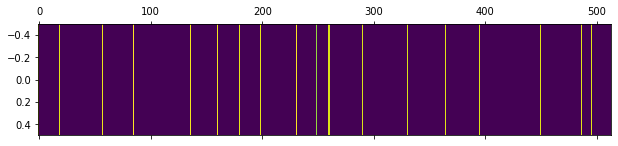

In [56]:
plt.matshow(prob.detach().numpy(), aspect=100)

In [57]:
torch.argsort(prob, descending=True)[:, 0:3]
# top-k sentence

tensor([[ 85, 231, 136]])

In [58]:
criterion = nn.BCELoss(reduction="none")
# 일단, reduction을 "none"으로 하고 모델의 loss가 각각에 대해 올바르게 계산되는지를 확인합니다.

In [59]:
criterion(prob, classification_label.unsqueeze(0))
# 현재는 batch가 아니라서 unsqueeze를 해줘야 합니다.

tensor([[0.6354, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.7416, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.6341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.7910, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [60]:
criterion = nn.BCELoss(reduction="sum")
loss = criterion(prob, classification_label.unsqueeze(0))
loss
# reduction을 "sum"으로 하면 각 batch별로 단일의 loss 값이 scalar 값으로 도출됩니다.
# 이 loss 값을 바탕으로 backward가 일어납니다.

tensor(13.0111, grad_fn=<BinaryCrossEntropyBackward>)

# Encoder -> Decoder 훈련

In [61]:
seleted_sentences = [input_sentences[idx] for idx in target_ids]
# 0번 문장이 대체로 title로 추정되는데, 이를 추가할지 말지도 여기서 결정해야 할 것 같습니다.

extracted_sentences = " ".join(seleted_sentences)
extracted_sentences
# generation-based summary에 사용될 문장을 만들어줍니다.

"맥라렌이 영국에서 새로운 '600LT 스파이더'를 공개했다. 맥라렌이 2019년 새롭게 선보이는 모델은 전설이 맥라렌 롱테일의 명성을 이어갈 5번째 롱테일이다. 맥라렌 600LT 스파이더는 쿠페와 마찬가지로 영국 워킹에 위치한 맥라렌 프로덕션 센터에서 수작업으로 조립되는 한정판이다."

In [62]:
input_ids = [tokenizer.bos_token_id] + tokenizer.encode(extracted_sentences) + [tokenizer.eos_token_id]
summary_ids = model.generate(torch.tensor([input_ids]), max_length=256, min_length=20, early_stopping=True, num_beams=20)
summary_ids

tensor([[    2, 16193, 10213, 10301, 12034, 15609, 15717, 13120, 11786, 17715,
         16193, 10213, 10301, 14430,  9807, 11300, 18627, 14030, 14032, 20356,
         14027, 14077, 10487, 14343, 19363, 13372, 14063,   253, 14079,   275,
           283, 14148, 19052,  9806, 15127, 14623, 15615,     1]])

In [63]:
tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)

"맥라렌이 영국 워킹에 위치한 맥라렌 프로덕션 센터에서 수작업으로 조립되는 한정판 '600LT 스파이더'를 공개했다."

이 요약 결과를 전체 문장을 넣었을 때와 비교해봅니다.

In [64]:
input_ids = [tokenizer.bos_token_id] + tokenizer.encode(" ".join(input_sentences)) + [tokenizer.eos_token_id]
summary_ids = model.generate(torch.tensor([input_ids]), max_length=256, min_length=20, early_stopping=True, num_beams=20)
tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)

"맥라렌이 맥라렌의 여섯 가지 LT 정신인 강력한 성능, 경량화 차체, 최적화된 공력 성능, 트랙 중심의 역동성, 드라이버와 완벽한 교감, 희소성 등을 아우르는 새로운 '600LT 스파이더'를 공개했다."

# Modeling